In [2]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
!ls "/content/gdrive/My Drive/Data-integration"

AutoencoderCITEseq.ipynb   scProteomics.txt
scATACseq.txt		   scRNAseq.txt
scBSseq.txt		   tSNE_on_Autoencoder_CITEseq.ipynb
scNMTseqAutoencoder.ipynb  tsne_on_autoencoder_scNMTseq.ipynb


In [ ]:
import numpy as np
import pandas as pd
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.utils import plot_model
from keras.layers import Input, Dense
from keras.layers.merge import concatenate

In [ ]:
work_dir = "/content/gdrive/My Drive/Data-integration"
scRNAseq = pd.read_csv(work_dir + '/scRNAseq.txt',sep='\t')
scProteomics = pd.read_csv(work_dir + '/scProteomics.txt',sep='\t')

X_scRNAseq = scRNAseq.values[:,0:(scRNAseq.shape[1]-1)]
Y_scRNAseq = scRNAseq.values[:,scRNAseq.shape[1]-1]
X_scProteomics = scProteomics.values[:,0:(scProteomics.shape[1]-1)]
Y_scProteomics = scProteomics.values[:,scProteomics.shape[1]-1]

X_scRNAseq = np.log(X_scRNAseq + 1)
X_scProteomics = np.log(X_scProteomics + 1)

In [ ]:
print('Shape of X_scRNAseq is ', X_scRNAseq.shape)
print('Shape of X_scProteomics is ', X_scProteomics.shape)

print('Shape of Y_scRNAseq is ', Y_scRNAseq.shape)
print('Shape of Y_scProteomics is ', Y_scProteomics.shape)

Shape of X_scRNAseq is  (8617, 976)
Shape of X_scProteomics is  (8617, 10)
Shape of Y_scRNAseq is  (8617,)
Shape of Y_scProteomics is  (8617,)


In [ ]:
# Input Layer
ncol_scRNAseq = X_scRNAseq.shape[1]
input_dim_scRNAseq = Input(shape = (ncol_scRNAseq, ), name = "scRNAseq")
ncol_scProteomics = X_scProteomics.shape[1]
input_dim_scProteomics = Input(shape = (ncol_scProteomics, ), name = "scProteomics")

In [ ]:
# Dimensions of Encoder for each OMIC
encoding_dim_scRNAseq = 50
encoding_dim_scProteomics = 10

In [ ]:
# Encoder layer for each OMIC
encoded_scRNAseq = Dense(encoding_dim_scRNAseq, activation = 'linear', 
                         name = "Encoder_scRNAseq")(input_dim_scRNAseq)
encoded_scProteomics = Dense(encoding_dim_scProteomics, activation = 'linear', 
                             name = "Encoder_scProteomics")(input_dim_scProteomics)

In [ ]:
# Merging Encoder layers from different OMICs
merge = concatenate([encoded_scRNAseq, encoded_scProteomics])

In [ ]:
# Bottleneck compression
bottleneck = Dense(50, kernel_initializer = 'uniform', activation = 'linear', 
                   name = "Bottleneck")(merge)

In [ ]:
#Inverse merging
merge_inverse = Dense(encoding_dim_scRNAseq + encoding_dim_scProteomics, 
                      activation = 'elu', name = "Concatenate_Inverse")(bottleneck)

In [ ]:
# Decoder layer for each OMIC
decoded_scRNAseq = Dense(ncol_scRNAseq, activation = 'sigmoid', 
                         name = "Decoder_scRNAseq")(merge_inverse)
decoded_scProteomics = Dense(ncol_scProteomics, activation = 'sigmoid', 
                             name = "Decoder_scProteomics")(merge_inverse)

In [ ]:
# Combining Encoder and Decoder into an Autoencoder model
autoencoder = Model(inputs = [input_dim_scRNAseq, input_dim_scProteomics], 
                    outputs = [decoded_scRNAseq, decoded_scProteomics])

In [ ]:
# Compile Autoencoder
autoencoder.compile(optimizer = 'adam', 
                    loss={'Decoder_scRNAseq': 'mean_squared_error', 
                          'Decoder_scProteomics': 'mean_squared_error'})
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scRNAseq (InputLayer)           [(None, 976)]        0                                            
__________________________________________________________________________________________________
scProteomics (InputLayer)       [(None, 10)]         0                                            
__________________________________________________________________________________________________
Encoder_scRNAseq (Dense)        (None, 50)           48850       scRNAseq[0][0]                   
__________________________________________________________________________________________________
Encoder_scProteomics (Dense)    (None, 10)           110         scProteomics[0][0]               
______________________________________________________________________________________________

## Autoencoder training

Epoch 1/100
54/54 [==============================] - 2s 17ms/step - loss: 18.3757 - Decoder_scRNAseq_loss: 0.3388 - Decoder_scProteomics_loss: 18.0370 - val_loss: 15.4016 - val_Decoder_scRNAseq_loss: 0.0929 - val_Decoder_scProteomics_loss: 15.3087
Epoch 2/100
54/54 [==============================] - 0s 8ms/step - loss: 17.0827 - Decoder_scRNAseq_loss: 0.2118 - Decoder_scProteomics_loss: 16.8710 - val_loss: 15.3890 - val_Decoder_scRNAseq_loss: 0.0805 - val_Decoder_scProteomics_loss: 15.3086
Epoch 3/100
54/54 [==============================] - 0s 7ms/step - loss: 17.1761 - Decoder_scRNAseq_loss: 0.1925 - Decoder_scProteomics_loss: 16.9836 - val_loss: 15.3876 - val_Decoder_scRNAseq_loss: 0.0790 - val_Decoder_scProteomics_loss: 15.3085
Epoch 4/100
54/54 [==============================] - 0s 8ms/step - loss: 17.0239 - Decoder_scRNAseq_loss: 0.1942 - Decoder_scProteomics_loss: 16.8297 - val_loss: 15.3862 - val_Decoder_scRNAseq_loss: 0.0777 - val_Decoder_scProteomics_loss: 15.3085
Epoch 5/100

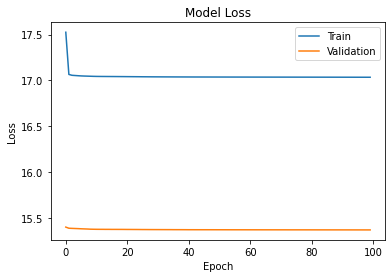

In [ ]:
estimator = autoencoder.fit([X_scRNAseq, X_scProteomics], 
                            [X_scRNAseq, X_scProteomics], 
                            epochs = 100, batch_size = 128, 
                            validation_split = 0.2, shuffle = True, verbose = 1)
print("Training Loss: ",estimator.history['loss'][-1])
print("Validation Loss: ",estimator.history['val_loss'][-1])
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper right')
plt.show()

In [ ]:
# Encoder model
encoder = Model(inputs = [input_dim_scRNAseq, input_dim_scProteomics], 
                outputs = bottleneck)
bottleneck_representation = encoder.predict([X_scRNAseq, X_scProteomics])

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 8617 samples in 0.056s...
[t-SNE] Computed neighbors for 8617 samples in 5.220s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8617
[t-SNE] Computed conditional probabilities for sample 2000 / 8617
[t-SNE] Computed conditional probabilities for sample 3000 / 8617
[t-SNE] Computed conditional probabilities for sample 4000 / 8617
[t-SNE] Computed conditional probabilities for sample 5000 / 8617
[t-SNE] Computed conditional probabilities for sample 6000 / 8617
[t-SNE] Computed conditional probabilities for sample 7000 / 8617
[t-SNE] Computed conditional probabilities for sample 8000 / 8617
[t-SNE] Computed conditional probabilities for sample 8617 / 8617
[t-SNE] Mean sigma: 1.637950
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.197067
[t-SNE] KL divergence after 1000 iterations: 1.555110


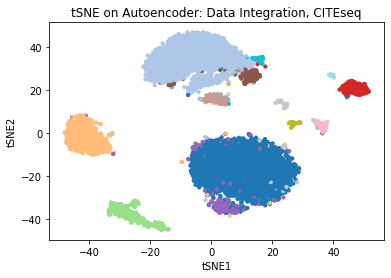

In [ ]:
# tSNE on Autoencoder bottleneck representation
model_tsne_auto = TSNE(learning_rate = 200, n_components = 2, random_state = 123, 
                       perplexity = 90, n_iter = 1000, verbose = 1)
tsne_auto = model_tsne_auto.fit_transform(bottleneck_representation)
plt.scatter(tsne_auto[:, 0], tsne_auto[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 10)
plt.title('tSNE on Autoencoder: Data Integration, CITEseq')
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.show()